In [ ]:
#pip install ee, testresources, geemap, geetools, scikit-image

In [1]:
import geetools
import geemap
import random
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import skimage
import time

In [2]:
import ee

ee.Authenticate()

True

In [3]:
ee.Initialize()

In [22]:
#define areas of interest: 
coords_jd = (39.0053612, 21.4210088, 39.3253612, 21.7410088)  # Jeddah
coords_md = (39.4511216, 24.311153, 39.7711216, 24.631153)   # Medina
coords_mk = (39.698,21.078,40.222,21.694)                      # Mecca
coords_tf = (40.2558308, 21.1102801, 40.5758308, 21.4302801)   # Taif
coords_rd = (46.5560104, 24.478916, 46.8760104, 24.798916) #Riyadh bbox
coord_rd = [[46.4328690955,24.1659202907],[46.6345003059,25.4285645773],[47.5182109888,25.2818982646],
             [47.5209967609,24.1956804525],[46.4328690955,24.1659202907]] #riyad polygon

def add_degree_buffer_to_coords(bbox_coords_tuple, buffer_deg):
    """
    Adds a buffer in degrees to a bounding box defined by a tuple of coordinates.
    Returns a new tuple of buffered coordinates.
    """
    minlon, minlat, maxlon, maxlat = bbox_coords_tuple
    return (minlon - buffer_deg, minlat - buffer_deg, maxlon + buffer_deg, maxlat + buffer_deg)


buffered_coords = add_degree_buffer_to_coords(coords_rd, 0.5)
bbox = ee.Geometry.BBox(*buffered_coords) 
bbox = ee.Geometry.Polygon([coord_rd])

# Landsat

In [6]:
#get Data: Landsat 
# Landsat collections (T1 = Tier 1 Surface Reflectance where available)
landsat1 = ee.ImageCollection("LANDSAT/LM01/C02/T1")
landsat2 = ee.ImageCollection("LANDSAT/LM02/C02/T1")
landsat3 = ee.ImageCollection("LANDSAT/LM03/C02/T1")
landsat4 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2")
landsat5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
landsat7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# Merge Landsat collections based on sensors
landsat_1_3 = landsat1.merge(landsat2).merge(landsat3).filterBounds(bbox).sort("DATE_ACQUIRED")

landsat_4_7 = landsat4.merge(landsat5).merge(landsat7).filterBounds(bbox).sort("DATE_ACQUIRED")

landsat8 = landsat8.filterBounds(bbox).sort("DATE_ACQUIRED")
# Get a single image
first_image_landsat = landsat8.first()

band_names = first_image_landsat.bandNames()
#print('Band Names:', band_names.getInfo())

# Print metadata properties
props = first_image_landsat.toDictionary()
#print('Metadata Keys:', props.keys().getInfo())

In [23]:
#find which tiles is needed 
def extract_path_row(img):
    return img.set({
        'path': img.get('WRS_PATH'),
        'row': img.get('WRS_ROW'),
        'footprint': img.geometry()
    })

meta = landsat_4_7.map(extract_path_row)

unique_tiles = meta.distinct(['path', 'row'])

# Get as list of dicts for inspection
tile_list = unique_tiles.aggregate_array('system:index').getInfo()
print(f"Found {len(tile_list)} distinct tiles.")

Map = geemap.Map(center=[22.0, 39.0], zoom=7)

# Add the distinct tiles as polygons
def draw_tile_footprints(img):
    geom = img.geometry()
    path = ee.Number(img.get('path')).format('%03d')
    row = ee.Number(img.get('row')).format('%03d')
    label = ee.String('Path: ').cat(path).cat(' Row: ').cat(row)
    Map.addLayer(geom, {'color': 'blue'}, label.getInfo())


tiles_list = unique_tiles.toList(unique_tiles.size())

for i in range(min(15, tiles_list.size().getInfo())):
    draw_tile_footprints(ee.Feature(tiles_list.get(i)))

Map.addLayer(bbox, {'color': 'red'}, 'Your BBOX') # for jeddah it is 45 
Map


Found 10 distinct tiles.


Map(center=[22.0, 39.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [6]:
#since for Jeddah 45 is enough we can filter for that one  
# Jeddah: Path: 170 Row: 045 
#Makkah path: 169, row 45
#riyadh 165, 43
WRS_PATH = 169
WRS_ROW = 45
landsat_1_3 = landsat_1_3.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))
landsat_4_7 = landsat_4_7.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))
landsat8    = landsat8.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', WRS_PATH),ee.Filter.eq('WRS_ROW', WRS_ROW))).map(lambda img: img.clip(bbox))

In [58]:
def get_landsat_collection(imgcol, path, row):
    """Returns a filtered and band-renamed Landsat collection."""
    return imgcol \
        .filter(ee.Filter.eq('WRS_PATH', path)) \
        .filter(ee.Filter.eq('WRS_ROW', row)) 

def mosaic_collections_by_date(ic1, ic2, bbox=None):
    """
    Merges two image collections and returns a daily mosaic ImageCollection.
    Optionally clips each mosaic to a bounding box.
    """
    merged = ic1.merge(ic2)
    timestamps = merged.aggregate_array('system:time_start').distinct()

    def mosaic_on_date(t):
        t = ee.Date(t)
        daily_images = merged.filterDate(t, t.advance(1, 'day'))
        mosaic = daily_images.mosaic().set('system:time_start', t.millis())
        return mosaic.clip(bbox) if bbox else mosaic

    return ee.ImageCollection(timestamps.map(mosaic_on_date))


path1, row1 = 170, 45
path2, row2 = 169, 45

# Get collections lansat 8
col1 = get_landsat_collection(landsat8,path1, row1)
col2 = get_landsat_collection(landsat8, path2, row2)
# Combine with date mosaicking
landsat8 = mosaic_collections_by_date(col1, col2)

# landsa 4-7
col3 = get_landsat_collection(landsat_4_7,path1, row1)
col4 = get_landsat_collection(landsat_4_7, path2, row2)
# Combine with date mosaicking
landsat_4_7 = mosaic_collections_by_date(col3, col4)

# Get collections
col5 = get_landsat_collection(landsat_1_3,path1, row1)
col6 = get_landsat_collection(landsat_1_3, path2, row2)
# Combine with date mosaicking
landsat_1_3 = mosaic_collections_by_date(col5, col6)



In [82]:
center = [21.5, 39.2] 
Map = geemap.Map(center=center, zoom=9)
Map.addLayer(first_image, vis_params, "Mosaic RGB")
Map.addLayer(bbox, {}, "Clip Boundary")
Map

EEException: Collection.first: Error in map(ID=1_0):
Image.reduceRegion: Provide 'geometry' parameter when aggregating over an unbounded image.

# Modis

In [ ]:
#get data: Modis 
#Terra
# MODIS Terra Surface Reflectance
modis_terra = ee.ImageCollection("MODIS/061/MOD11A1").filterBounds(bbox_jd)

# MODIS Aqua Surface Reflectance
modis_aqua = ee.ImageCollection("MODIS/061/MYD11A1").filterBounds(bbox_jd)

# Merge MODIS collections
modis_all = modis_terra.merge(modis_aqua)

# Filter by location
modis = modis_all.filterBounds(bbox)

first_image = modis.filterDate('2025-06-01','2025-06-17' ).first()

# List all band names
band_names = first_image.bandNames()
print('Band Names:', band_names.getInfo())

# Print metadata properties
props = first_image.toDictionary()
print('Metadata Keys:', props.keys().getInfo())


In [ ]:
modis.size().getInfo()

In [15]:
#Get time ranges 
modis_start = ee.Date(modis_terra.sort('system:time_start').first().get('system:time_start')).format('YYYY-MM-dd')
modis_end = ee.Date(modis_terra.sort('system:time_start', False).first().get('system:time_start')).format('YYYY-MM-dd')

print('MODIS Terra date range:')
print('Start:', modis_start.getInfo())
print('End  :', modis_end.getInfo())

modisa_start = ee.Date(modis_aqua.sort('system:time_start').first().get('system:time_start')).format('YYYY-MM-dd')
modisa_end = ee.Date(modis_aqua.sort('system:time_start', False).first().get('system:time_start')).format('YYYY-MM-dd')

print('MODIS aqua date range:')
print('Start:', modisa_start.getInfo())
print('End  :', modisa_end.getInfo())



NameError: name 'modis_terra' is not defined

In [17]:
landsat_start = ee.Date(landsat_indexed.sort('system:time_start').first().get('system:time_start')).format('YYYY-MM-dd')
landsat_end = ee.Date(landsat_indexed.sort('system:time_start', False).first().get('system:time_start')).format('YYYY-MM-dd')

print('landsat date range:')
print('Start:', landsat_start.getInfo())
print('End  :', landsat_end.getInfo())

landsat date range:
Start: 1984-06-06
End  : 2025-07-09


In [ ]:
print("Landsat image count:", landsat8.size().getInfo())

# Landsat Processing

In [59]:
#cloud masking 
def maskL457sr(image):
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)
    return image.updateMask(qa_mask).updateMask(saturation_mask).copyProperties(image, ['system:time_start'])

def maskL8sr(image):
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)
    return image.updateMask(qa_mask).updateMask(saturation_mask).copyProperties(image, ['system:time_start'])
    

In [60]:
# Rescale bands 
def rescaleL457sr(image):
    # Keep band names intact
    optical = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) \
                   .multiply(0.0000275).add(-0.2)
    thermal = image.select('ST_B6').multiply(0.00341802).add(149.0)

    return image.addBands(optical, overwrite=True).addBands(thermal, overwrite=True)
def rescaleL8sr(image):
    # Optical scaling
    optical = image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
                   .multiply(0.0000275).add(-0.2)
    # Thermal scaling
    thermal = image.select('ST_B10').multiply(0.00341802).add(149.0)
    return image.addBands(optical, overwrite=True).addBands(thermal, overwrite=True)


In [61]:
#band rename 
def renameL457(image):
    band_names = image.bandNames()

    sr_map = {
        'SR_B1': 'blue',
        'SR_B2': 'green',
        'SR_B3': 'red',
        'SR_B4': 'nir',
        'SR_B5': 'swir1',
        'SR_B7': 'swir2'
    }

    # Only rename existing bands
    available_sr = [k for k in sr_map if band_names.contains(k)]
    renamed = [sr_map[k] for k in available_sr]

    optical = ee.Image(
        ee.Algorithms.If(
            ee.List(available_sr).size().gt(0),
            image.select(available_sr).rename(renamed),
            ee.Image()
        )
    )

    thermal = ee.Image(
        ee.Algorithms.If(
            band_names.contains('ST_B6'),
            image.select('ST_B6').rename(['thermal']),
            ee.Image()
        )
    )

    qa = ee.Image(
        ee.Algorithms.If(
            band_names.contains('QA_PIXEL'),
            image.select('QA_PIXEL'),
            ee.Image()
        )
    )

    return ee.Image.cat([optical, thermal, qa]).copyProperties(image, image.propertyNames())

def renameL8sr(image):
    band_names = image.bandNames()

    sr_map = {
        'SR_B2': 'blue',
        'SR_B3': 'green',
        'SR_B4': 'red',
        'SR_B5': 'nir',
        'SR_B6': 'swir1',
        'SR_B7': 'swir2'
    }

    available_sr = [k for k in sr_map if band_names.contains(k)]
    renamed = [sr_map[k] for k in available_sr]

    optical = ee.Image(
        ee.Algorithms.If(
            ee.List(available_sr).size().gt(0),
            image.select(available_sr).rename(renamed),
            ee.Image()
        )
    )

    thermal = ee.Image(
        ee.Algorithms.If(
            band_names.contains('ST_B10'),
            image.select('ST_B10').rename(['thermal']),
            ee.Image()
        )
    )

    qa = ee.Image(
        ee.Algorithms.If(
            band_names.contains('QA_PIXEL'),
            image.select('QA_PIXEL'),
            ee.Image()
        )
    )

    return ee.Image.cat([optical, thermal, qa]).copyProperties(image, image.propertyNames())


In [62]:
#apply processing
landsat_4_7 = landsat_4_7.map(maskL457sr).map(rescaleL457sr).map(renameL457)
landsat8 = landsat8.map(maskL8sr).map(rescaleL8sr).map(renameL8sr)
landsat = landsat_4_7.merge(landsat8)

# Landsat Indices

In [63]:
# --- Define Index Calculation Functions ---
def add_ndvi(image):
    return image.addBands(image.normalizedDifference(['nir', 'red']).rename('NDVI'))

def add_ndbi(image):
    return image.addBands(image.normalizedDifference(['swir1', 'nir']).rename('NDBI'))

def add_bsi(image):
    # Use expression for BSI for clarity and robustness
    bsi = image.expression(
        '((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))',
        {
            'SWIR1': image.select('swir1'),
            'RED': image.select('red'),
            'NIR': image.select('nir'),
            'BLUE': image.select('blue')
        }
    ).rename('BSI')
    return image.addBands(bsi)
    
def add_ndwi(image):
    ndwi = image.normalizedDifference(['green', 'nir']).rename('NDWI')
    return image.addBands(ndwi)


def apply_indices(image):
    image = ee.Image(image) # Ensure input is an ee.Image

    # Check if image has required bands before attempting index calculation
    has_optical_bands = image.bandNames().containsAll(['blue', 'green', 'red', 'nir', 'swir1'])
    
    # Create an initial "indexed" image based on whether optical bands exist
    indexed_image = ee.Algorithms.If(
        has_optical_bands,
        add_ndvi(image),
        image # If no optical bands, return original (un-indexed) image
    )
    indexed_image = ee.Image(indexed_image) # Cast after first index
    
    indexed_image = ee.Algorithms.If(
        has_optical_bands,
        add_ndbi(indexed_image),
        indexed_image
    )
    indexed_image = ee.Image(indexed_image)

    indexed_image = ee.Algorithms.If(
        has_optical_bands,
        add_bsi(indexed_image),
        indexed_image
    )
    indexed_image = ee.Image(indexed_image)

    indexed_image = ee.Algorithms.If(
        has_optical_bands,
        add_ndwi(indexed_image),
        indexed_image
    )
    indexed_image = ee.Image(indexed_image)
    return indexed_image.copyProperties(image, image.propertyNames()) # Copy all properties
    
landsat_indexed = landsat.map(apply_indices)

In [54]:
#get mena time series 
def extract_mean_indices(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bbox_jd,
        scale=1000,
        maxPixels=1e9
    )
    # Add image date as property
    date = img.date().format('YYYY-MM-dd')
    return ee.Feature(None, stats).set('date', date)

features = landsat_indexed.map(extract_mean_indices).filter(
    ee.Filter.notNull(['NDVI', 'NDBI', 'BSI', 'NDWI'])
)
fc = ee.FeatureCollection(features)

import pandas as pd

# Get the data as a client-side list
data = features.aggregate_array('date').getInfo()
ndvi = features.aggregate_array('NDVI').getInfo()
ndbi = features.aggregate_array('NDBI').getInfo()
bsi  = features.aggregate_array('BSI').getInfo()
ndwi  = features.aggregate_array('NDWI').getInfo()

# Create DataFrame
df = pd.DataFrame({
    'Date': pd.to_datetime(data),
    'NDVI': ndvi,
    'NDBI': ndbi,
    'BSI': bsi, #check why bsi is not boanded by 1? was it rescaled correctly? 
    'NDWI': ndwi
}).sort_values('Date')

# Plot
import matplotlib.pyplot as plt

df.set_index('Date').plot(figsize=(12, 6), title=' Indices Time Series')
plt.ylabel("Value")
plt.grid(True)
plt.show()



KeyboardInterrupt: 

In [ ]:
'''
# Filter for summer months: May (5) to August (8)
summer = landsat_indexed.filter(ee.Filter.calendarRange(5, 8, 'month'))

# Create a list of start days (day-of-year) for 16-day windows between May–Aug
start_doys = ee.List.sequence(121, 243, 16)

# Function to generate a 16-day NDVI composite
def make_composite(start_doy):
    start_doy = ee.Number(start_doy)
    end_doy = start_doy.add(15)
    
    # Filter by DOY range
    filtered = summer.filter(
        ee.Filter.calendarRange(start_doy, end_doy, 'day_of_year')
    )
    
    # Take median NDVI
    ndvi_median = filtered.select('NDVI').median()
    
    # Add a label to the image
    return ndvi_median.set('label', ee.String('DOY_').cat(start_doy.format()).cat('_').cat(end_doy.format()))

# Map over the start_doys to make composites
composite_list = start_doys.map(make_composite)

# Convert list to an ImageCollection
composites = ee.ImageCollection.fromImages(composite_list)

# Set visualization parameters
ndvi_vis = {
    'min': -1.0,
    'max': 1.0,
    'palette': ['blue', 'white', 'green']
}

# Define center or use bounds from your data
# Create a map
Map = geemap.Map(center=[21.5, 39.2], zoom=9)

# Convert to list
comp_list = composites.toList(composites.size())

# Loop using index (safest for user-defined collections)
for i in range(comp_list.size().getInfo()):
    img = ee.Image(comp_list.get(i))
    label = img.get('label').getInfo()
    Map.addLayer(img, ndvi_vis, f"NDVI {label}")
    
Map
'''

## Landsat lst

In [64]:
#for landsat 8-4
# from https://www.mdpi.com/2073-4433/16/6/712 
def add_lst(image):
    ndvi = image.select('NDVI')
    bt = image.select('thermal')

    # Dynamic min/max per image
    ndvi_min = ndvi.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e9
    ).get('NDVI')
    
    ndvi_max = ndvi.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e9
    ).get('NDVI')

    ndvi_min = ee.Number(ndvi_min)
    ndvi_max = ee.Number(ndvi_max)

    # Fraction of vegetation
    fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')

    # Emissivity
    em = fv.multiply(0.004).add(0.986).rename('EM')

    # Constants
    wavelength = 10.895e-6  # in meters
    rho = 1.438e-2

    # LST expression
    lst = bt.expression(
        'BT / (1 + (lambda * BT / rho) * log(EM)) - 273.15',
        {
            'BT': bt,
            'EM': em,
            'lambda': wavelength,
            'rho': rho
        }
    ).rename('LST')

    return image.addBands([fv, em, lst])

landsat_indexed = landsat_indexed.map(add_lst)

In [74]:
# Select first image
first_image = landsat_indexed.first()
lst_band = first_image.select('LST')

region = bbox  

# Compute stats
lst_stats = lst_band.reduceRegion(
    reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), '', True)
            .combine(ee.Reducer.max(), '', True),
    geometry=bbox, 
    scale=30,
    maxPixels=1e9
)
print('LST Statistics:', lst_stats.getInfo())

Map = geemap.Map(center=[21.5, 39.2], zoom=8)

# Visualization parameters for LST in °C
lst_vis = {
    'min': 20,
    'max': 45,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

Map.addLayer(first_image, lst_vis, 'LST (°C)')
Map.centerObject(bbox, zoom=9)
Map.addLayer(bbox, {'color': 'white'}, 'Bounding Box')
Map.addLayerControl()
Map


AttributeError: 'Reducer' object has no attribute 'clip'

In [67]:
# Get the first image from a filtered collection
first_img = landsat_indexed.first()

# Then reduce region on that image
stats = first_img.reduceRegion(
    reducer=ee.Reducer.mean()
              .combine(ee.Reducer.min(), '', True)
              .combine(ee.Reducer.max(), '', True),
    geometry=bbox,
    scale=30,
    maxPixels=1e9
)


In [69]:
print(landsat_indexed.size().getInfo())


1776


In [70]:
print(landsat_indexed.first().bandNames().getInfo())


EEException: Collection.first: Error in map(ID=1_0):
Image.reduceRegion: Provide 'geometry' parameter when aggregating over an unbounded image.

In [ ]:
# another method 
#from https://code.earthengine.google.com/?accept_repo=users/sofiaermida/landsat_smw_lst


In [ ]:
ndvi_collection = landsat_indexed.map(lambda img: img.select('NDVI'))
ndbi_collection = landsat_indexed.map(lambda img: img.select('NDBI'))
bsi_collection = landsat_indexed.map(lambda img: img.select('BSI'))
ndwi_collection = landsat_indexed.map(lambda img: img.select('NDWI'))
lst_collection = landsat_indexed.map(lambda img: img.select('LST'))


# Step 3: Compute median composites
# Add checks for empty collections to prevent errors if no data.
ndvi_median = ee.Algorithms.If(ndvi_collection.size().gt(0), ndvi_collection.median().clip(bbox), ee.Image(0).rename('NDVI'))
ndbi_median = ee.Algorithms.If(ndbi_collection.size().gt(0), ndbi_collection.median().clip(bbox), ee.Image(0).rename('NDBI'))
bsi_median = ee.Algorithms.If(bsi_collection.size().gt(0), bsi_collection.median().clip(bbox), ee.Image(0).rename('BSI'))
ndwi_median = ee.Algorithms.If(ndwi_collection.size().gt(0), ndwi_collection.median().clip(bbox), ee.Image(0).rename('NDWI'))
lst_median = ee.Algorithms.If(lst_collection.size().gt(0), lst_collection.median().clip(bbox), ee.Image(0).rename('LST'))


# Cast back to ee.Image
ndvi_median = ee.Image(ndvi_median)
ndbi_median = ee.Image(ndbi_median)
bsi_median = ee.Image(bsi_median)
ndwi_median = ee.Image(ndwi_median)
lst_median = ee.Image(lst_median)


# Step 4: Visualization parameters
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['white', 'green']} # Adjusted min for typical vegetation
ndbi_vis = {'min': -1, 'max': 1, 'palette': ['gray', 'white', 'black']}
bsi_vis = {'min': -1, 'max': 1, 'palette': ['white', 'yellow']} # More common range for BSI
ndwi_vis = {'min': -1, 'max': 1, 'palette': ['blue', 'white']}
#lst_vis = {'min': 10, 'max': 70, 'palette': ['blue', 'red']}

# Step 5: Display on map
Map = geemap.Map(center=[21.5, 39.2], zoom=9) # Center closer to Jeddah, higher zoom
Map.centerObject(bbox, zoom=8)
#Map.addLayer(ndvi_median, ndvi_vis, 'NDVI')
#Map.addLayer(ndbi_median, ndbi_vis, 'NDBI')
#Map.addLayer(bsi_median, bsi_vis, 'BSI') #check range is not -1 to 1
#Map.addLayer(ndwi_median, ndwi_vis, 'NDWI')
Map.addLayer(lst_median, lst_vis, 'LST')
Map.addLayer(bbox, {'color': 'FF0000'}, 'Jeddah BBox')

Map.addLayerControl()
Map

# Landsat UHI

In [ ]:
urban_mask = ndbi_image.select('NDBI').gt(0.1)  # You can tune threshold
rural_mask = ndvi_image.select('NDVI').gt(0.3).And(ndvi_image.select('NDBI').lt(0))
urban_LST = lst_image.updateMask(urban_mask)
rural_LST = lst_image.updateMask(rural_mask)

# Reduce to region mean
urban_mean = urban_LST.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=your_region,
    scale=1000,
    maxPixels=1e9
).get('LST_C')

rural_mean = rural_LST.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=your_region,
    scale=1000,
    maxPixels=1e9
).get('LST_C')

suhi = ee.Number(urban_mean).subtract(rural_mean)


# inspcet the data 

In [ ]:
#inspect 
geemap.ee_initialize()

# Define inspection function that returns a Feature
def inspect_image(img):
    stats = img.select('LST').reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=bbox,
        scale=30,
        maxPixels=1e9
    )

    return ee.Feature(None, {
        'image_id': img.id(),
        'LST_min': stats.get('LST_min'),
        'LST_max': stats.get('LST_max')
    })

# Apply over a limited number of images
features = landsat_indexed.limit(10).map(inspect_image)

# Convert to FeatureCollection
fc = ee.FeatureCollection(features)

# Export to CSV
#geemap.ee_to_csv(fc, filename='lst_band_stats.csv')


In [ ]:

def get_histogram(image, band='LST', region=bbox, scale=30):
    # Get histogram as dictionary: buckets and counts
    hist_dict = image.select(band).reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=256),
        geometry=region,
        scale=scale,
        bestEffort=True,
        maxPixels=1e9
    ).get(band)
    return hist_dict

# Get histogram dictionary for first image LST band
hist = get_histogram(landsat_indexed.first()).getInfo()

buckets = hist['bucketMeans']  # midpoints of bins
counts = hist['histogram']     # counts per bin

plt.figure(figsize=(10,6))
plt.bar(buckets, counts, width=(buckets[1] - buckets[0]))
plt.xlabel('LST (°C)')
plt.ylabel('Pixel count')
plt.title('Histogram of LST for first Landsat image')
plt.show()


# Export

In [26]:
#exlude dates where there are null and keep getting errors
exclude_ids = ['1_1_2_LT05_170045_19871122', '1_1_2_LT05_170045_19881226', '2_LC08_170045_20160801']
landsat_indexed = landsat_indexed.filter(ee.Filter.inList('system:index', exclude_ids).Not())
#make sure all data type match
def cast_to_float(image):
    return image.toFloat()

landsat_indexed = landsat_indexed.map(cast_to_float)


In [13]:
def collection_to_array(collection, region, scale, band, max_images):
    collection_list = collection.limit(max_images).toList(max_images)
    arrays = []
    target_shape = None

    example_img = ee.Image(collection_list.get(0)).select(band[0] if isinstance(band, list) else band) \
        .reproject(crs=target_crs, scale=target_scale)
    proj_info = example_img.projection().getInfo()
    

    for i in range(max_images):
        try:
            img = ee.Image(collection_list.get(i))
            selected_band = band[0] if isinstance(band, list) else band
            band_img = img.select(selected_band).reproject(crs=target_crs, scale=target_scale)


            band_img = img.select(selected_band) # Always select a single string band name

            arr = geemap.ee_to_numpy(band_img, region=region, scale=scale)

            if arr is not None and arr.size > 0:
                # Important: After ee_to_numpy, the array should be 2D (height, width).
                # If it's (height, width, 1), we need to squeeze it.
                if arr.ndim == 3 and arr.shape[2] == 1:
                    arr = arr.squeeze(axis=2) # Remove the last dimension if it's 1

                if arr.ndim != 2:
                    print(f"Warning: Array for image {i} (band {selected_band}) is not 2D after processing. Shape: {arr.shape}. Skipping.")
                    continue

                if target_shape is None:
                    target_shape = arr.shape
                    arrays.append(arr)
                else:
                    if arr.shape != target_shape:
                        #print(f"Warning: Image {i} (band {selected_band}) has shape {arr.shape}, expected {target_shape}. Resizing...")
                        resized_arr = np.full(target_shape, np.nan, dtype=arr.dtype)
                        rows_to_copy = min(arr.shape[0], target_shape[0])
                        cols_to_copy = min(arr.shape[1], target_shape[1])
                        resized_arr[:rows_to_copy, :cols_to_copy] = arr[:rows_to_copy, :cols_to_copy]
                        arrays.append(resized_arr)
                    else:
                        arrays.append(arr)
            else:
                print(f"Skipping image {i} (band {selected_band}) because it returned an empty or None array.")

        except Exception as e:
            print(f"Skipping image {i} (band {selected_band}) due to error: {e}")
            continue

    if arrays:
        stacked = np.stack(arrays, axis=0)
        return stacked
    else:
        return None

        
def stack_bands_to_4D(collection, region, scale, band_names, max_images):
    band_arrays = []

    for band in band_names:
        #print(f"Processing band: {band}")
        arr = collection_to_array(collection, region, scale, band, max_images)
        if arr is not None:
            band_arrays.append(arr)
        else:
            print(f"Skipping band {band} due to failed extraction.")

    # Stack along last axis: shape will be (time, rows, cols, bands)
    if band_arrays:
        stacked_4d = np.stack(band_arrays, axis=-1)
        return stacked_4d
    else:
        return None


def to_geotiff_stack(stacked_array, region_bounds, band_names, dates, out_dir, crs='EPSG:4326'):
    """
    Writes one GeoTIFF file per time slice.
    
    Parameters:
        stacked_array: 4D np.array (time, rows, cols, bands)
        region_bounds: (west, south, east, north)
        band_names: list of band names
        dates: list of datetime or str
        out_dir: folder to save TIFFs
    """
    time_dim, height, width, num_bands = stacked_array.shape
    transform = from_bounds(*region_bounds, width=width, height=height)

    os.makedirs(out_dir, exist_ok=True)

    for t in range(time_dim):
        date_str = dates[t] if isinstance(dates[t], str) else dates[t].strftime('%Y-%m-%d')
        file_path = os.path.join(out_dir, f"{date_str}.tif")

        with rasterio.open(
            file_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=num_bands,
            dtype=stacked_array.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            for b in range(num_bands):
                dst.write(stacked_array[t, :, :, b], b + 1)
                dst.set_band_description(b + 1, band_names[b])

        print(f"Saved {file_path}")

def save_stack_to_netcdf(stacked_array, band_names, dates, region_bounds, out_path, crs='EPSG:4326'):
    """
    Save a 4D numpy array to NetCDF.
    
    Parameters:
    - stacked_array: numpy array with shape (time, lat, lon, bands)
    - band_names: list of band names (length = bands)
    - dates: list of datetime objects or strings (length = time)
    - region_bounds: tuple (west, south, east, north) in degrees
    - out_path: output netCDF file path
    - crs: coordinate reference system string (default: EPSG:4326)
    """

    time_dim, lat_dim, lon_dim, band_dim = stacked_array.shape

    west, south, east, north = region_bounds
    
    # Generate 1D coordinate arrays for latitude and longitude
    lats = np.linspace(north, south, lat_dim)  # descending order (north to south)
    lons = np.linspace(west, east, lon_dim)
    
    # Convert dates to pandas datetime index if strings
    if isinstance(dates[0], str):
        times = pd.to_datetime(dates)
    else:
        times = pd.to_datetime(dates)

    # Create xarray DataArray with dims and coords
    da = xr.DataArray(
        data=stacked_array,
        dims=["time", "lat", "lon", "band"],
        coords={
            "time": times,
            "lat": lats,
            "lon": lons,
            "band": band_names
        },
        name="LandsatData"
    )
    
    # Add CRS as an attribute
    da.attrs["crs"] = crs

    # Wrap in Dataset for potential multiple variables
    ds = xr.Dataset({"LandsatData": da})

    # Save to NetCDF
    ds.to_netcdf(out_path)
    print(f"Saved NetCDF to {out_path}")

def get_image_dates(collection, max_images=40):
    collection = collection.limit(max_images)
    timestamps = collection.aggregate_array('system:time_start').getInfo()
    dates = [datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d') for ts in timestamps]
    return dates

In [18]:
import os
import numpy as np
import rasterio
from rasterio.transform import from_bounds

def to_geotiff_stack(stacked_array, region_bounds, band_names, dates, out_dir, crs='EPSG:4326'):
    """
    Writes one GeoTIFF file per band, where each file contains time as the band dimension.
    
    Parameters:
        stacked_array: 4D np.array (time, lat, lon, bands)
        region_bounds: (west, south, east, north)
        band_names: list of band names
        dates: list of datetime or str (used for band descriptions)
        out_dir: folder to save TIFFs
        crs: Coordinate reference system
    """
    time_dim, height, width, num_bands = stacked_array.shape
    transform = from_bounds(*region_bounds, width=width, height=height)
    os.makedirs(out_dir, exist_ok=True)

    for b in range(num_bands):
        band_array = stacked_array[:, :, :, b]  # shape: (time, lat, lon)
        file_path = os.path.join(out_dir, f"{band_names[b]}.tif")

        with rasterio.open(
            file_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=time_dim,
            dtype=stacked_array.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            for t in range(time_dim):
                dst.write(band_array[t, :, :], t + 1)
                if dates:
                    date_str = dates[t] if isinstance(dates[t], str) else dates[t].strftime('%Y-%m-%d')
                    dst.set_band_description(t + 1, date_str)

        print(f"Saved {file_path}")


In [16]:
len(get_image_dates(landsat_indexed, 900))

871

In [32]:
#save as NC
bands = ee.Image(landsat_indexed.first()).bandNames().getInfo()
dates = get_image_dates(landsat_indexed)

out_path = "jd_landsat_stack.nc"
stacked = stack_bands_to_4D(landsat_indexed, bbox, scale=1000, band_names=bands, max_images=40)
save_stack_to_netcdf(stacked, bands, dates, coords_jd, out_path)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Saved NetCDF to jd_landsat_stack.nc


In [21]:
import time
import numpy as np
import math

def resize_to_match(array, target_shape):
    """Resize a 4D array to match the target shape (time, lat, lon, band)."""
    from skimage.transform import resize
    resized = []
    for i in range(array.shape[0]):
        img = array[i]
        resized_img = resize(img, target_shape[1:], order=1, preserve_range=True, anti_aliasing=True)
        resized.append(resized_img)
    return np.stack(resized, axis=0)
    
def get_chunked_stack(image_collection, region, scale, band_names, chunk_size=40, sleep_time=3):
    """Download the image collection in chunks and stack them."""
    image_collection = image_collection.limit(80)
    total_images = image_collection.size().getInfo()
    num_chunks = math.ceil(total_images / chunk_size)
    
    all_stacks = []
    all_dates = []

    for i in range(num_chunks):
        print(f"Processing chunk {i+1}/{num_chunks}")
        start = i * chunk_size
        end = min(start + chunk_size, total_images)
        
        chunk = image_collection.toList(chunk_size, start)
        chunk_ic = ee.ImageCollection(chunk)

        try:
            dates_chunk = get_image_dates(chunk_ic)
            stack_chunk = stack_bands_to_4D(chunk_ic, region, scale=scale, band_names=band_names, max_images=chunk_size)
            all_stacks.append(stack_chunk)
            all_dates.extend(dates_chunk)
        except Exception as e:
            print(f"Chunk {i+1} failed: {e}")
        
        time.sleep(sleep_time)  # respect GEE quotas
    
            # Get the target shape from the first stack
        target_shape = all_stacks[0].shape
        
        # Resize each to the same shape
        resized_stacks = [resize_to_match(a, target_shape) if a.shape != target_shape else a for a in all_stacks]
        
        # Concatenate safely
        stacked_final = np.concatenate(resized_stacks, axis=0)
    return stacked_final, all_dates

bands = ee.Image(landsat_indexed.first()).bandNames().getInfo()

get_chunked_stack(landsat_indexed, bbox, 1000, bands, sleep_time=5)

Processing chunk 1/2


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Processing chunk 2/2


(array([[[[6.48800000e-02, 6.26250000e-02, 5.68775000e-02, ...,
           2.23134363e-01, 9.86892537e-01, 2.91944883e+01],
          [6.44400000e-02, 6.25975000e-02, 5.53375000e-02, ...,
           2.32232428e-01, 9.86928930e-01, 2.91988117e+01],
          [6.42200000e-02, 6.34775000e-02, 5.65750000e-02, ...,
           2.25922932e-01, 9.86903692e-01, 2.91730733e+01],
          ...,
          [1.12290000e-01, 1.65612500e-01, 1.97567500e-01, ...,
           2.87889425e-01, 9.87151558e-01, 5.31537499e+01],
          [1.04645000e-01, 1.53375000e-01, 1.82580000e-01, ...,
           2.81919021e-01, 9.87127676e-01, 5.10023376e+01],
          [9.96950000e-02, 1.46032500e-01, 1.72432500e-01, ...,
           2.80474766e-01, 9.87121899e-01, 5.00912604e+01]],
 
         [[6.45500000e-02, 6.29000000e-02, 5.67125000e-02, ...,
           2.24838623e-01, 9.86899354e-01, 2.90805329e+01],
          [6.43575000e-02, 6.36975000e-02, 5.72900000e-02, ...,
           2.23334166e-01, 9.86893337e-01, 2.91153

In [ ]:
#save geo tiff 
bands = ee.Image(landsat_indexed.first()).bandNames().getInfo()
dates = get_image_dates(landsat_indexed,872)
stacked = stack_bands_to_4D(landsat_indexed, bbox, scale=1000, band_names=bands, max_images=872)
#to_geotiff_stack(stacked, region_bounds=coords_jd, band_names=bands, dates=dates, out_dir='jeddah_landsat')

In [23]:
to_geotiff_stack(stacked, region_bounds=coords_jd, band_names=bands, dates=dates, out_dir='jeddah_landsat_tiff')


Saved jeddah_landsat_tiff/blue.tif
Saved jeddah_landsat_tiff/green.tif
Saved jeddah_landsat_tiff/red.tif
Saved jeddah_landsat_tiff/nir.tif
Saved jeddah_landsat_tiff/swir1.tif
Saved jeddah_landsat_tiff/swir2.tif
Saved jeddah_landsat_tiff/thermal.tif
Saved jeddah_landsat_tiff/QA_PIXEL.tif
Saved jeddah_landsat_tiff/NDVI.tif
Saved jeddah_landsat_tiff/NDBI.tif
Saved jeddah_landsat_tiff/BSI.tif
Saved jeddah_landsat_tiff/NDWI.tif
Saved jeddah_landsat_tiff/FV.tif
Saved jeddah_landsat_tiff/EM.tif
Saved jeddah_landsat_tiff/LST.tif


In [24]:
# Split by year and export
start_year = 2023
end_year = 2024

for year in range(start_year, end_year + 1):
    start = ee.Date(f"{year}-01-01")
    end = ee.Date(f"{year}-12-31")
    
    yearly_collection = landsat_indexed.filterDate(start, end)

    def export_image(img):
        date_str = ee.Date(img.get("system:time_start")).format("YYYYMMdd").getInfo()
        task = ee.batch.Export.image.toDrive(
            image=img.clip(bbox),
            description=f"LST_Jeddah_{date_str}",
            folder="GEE_LST_TIMESERIES",
            fileNamePrefix=f"Mecca_Jeddah_{date_str}",
            region=bbox,
            scale=30,
            maxPixels=1e13
        )
        task.start()
        print(f"Export started for {date_str}")

    # Export all images for the year
    images = yearly_collection.toList(yearly_collection.size())
    for i in range(images.size().getInfo()):
        export_image(ee.Image(images.get(i)))

KeyboardInterrupt: 

In [27]:

# Set year range
start_year = 1984
end_year = 2024

# Sleep interval in seconds
sleep_seconds = 10

# Define image export function
def export_image(img, index):
    try:
        date_str = ee.Date(img.get("system:time_start")).format("YYYYMMdd").getInfo()
        task = ee.batch.Export.image.toDrive(
            image=img.clip(bbox),
            description=f"LST_Jeddah_{date_str}_{index}",
            folder="GEE_LST_TIMESERIES",
            fileNamePrefix=f"Jeddah_LST_{date_str}",
            region=bbox,
            scale=30,
            maxPixels=1e13
        )
        task.start()
        print(f"Started export for {date_str} (Index {index})")
        time.sleep(sleep_seconds)
    except Exception as e:
        print(f"Failed to export image at index {index}: {e}")
        time.sleep(sleep_seconds)

# Export all images year by year
for year in range(start_year, end_year + 1):
    start = ee.Date(f"{year}-01-01")
    end = ee.Date(f"{year}-12-31")
    yearly_collection = landsat_indexed.filterDate(start, end)
    image_list = yearly_collection.toList(yearly_collection.size())
    num_images = image_list.size().getInfo()
    
    print(f"Processing year {year} with {num_images} images")

    for i in range(num_images):
        img = ee.Image(image_list.get(i))
        export_image(img, index=i)


Processing year 1984 with 7 images
Started export for 19840606 (Index 0)
Started export for 19840622 (Index 1)
Started export for 19840910 (Index 2)
Started export for 19841012 (Index 3)
Started export for 19841028 (Index 4)
Started export for 19841113 (Index 5)
Started export for 19841129 (Index 6)
Processing year 1985 with 2 images
Started export for 19850201 (Index 0)
Started export for 19850217 (Index 1)
Processing year 1986 with 6 images
Started export for 19860103 (Index 0)
Started export for 19860220 (Index 1)
Started export for 19860308 (Index 2)
Started export for 19860628 (Index 3)
Started export for 19860815 (Index 4)
Started export for 19860916 (Index 5)
Processing year 1987 with 13 images
Started export for 19870106 (Index 0)
Started export for 19870122 (Index 1)
Started export for 19870207 (Index 2)
Started export for 19870311 (Index 3)
Started export for 19870327 (Index 4)
Started export for 19870412 (Index 5)
Started export for 19870514 (Index 6)
Started export for 1987

KeyboardInterrupt: 

/home/gahwagrw/.local/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


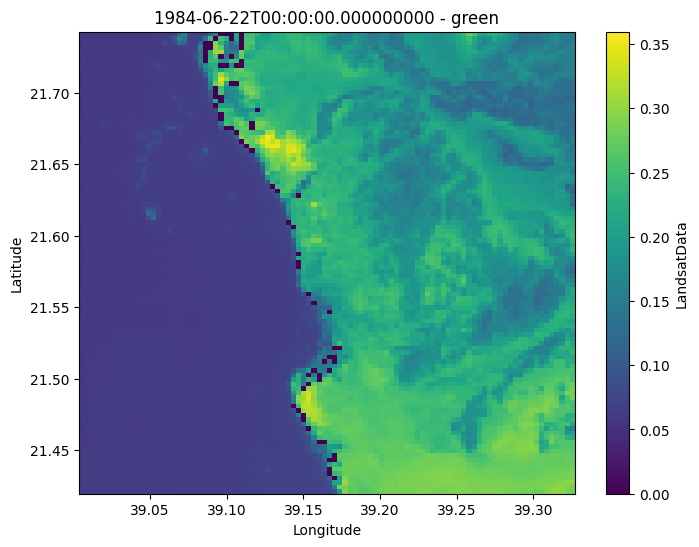

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset('/mnt/datawaha/hyex/gahwagrw/SaudiUHI/SASUHI/jd_landsat.nc')

# Example: plot band 3 (e.g., 'red') at time index 0
time_index = 1
band_index = 1  # zero-based

da = ds["LandsatData"].isel(time=time_index, band=band_index)

plt.figure(figsize=(8, 6))
da.plot(cmap='viridis')
plt.title(f"{ds.time[time_index].values} - {ds.band[band_index].values}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [10]:
ds = xr.open_dataset("/mnt/datawaha/hyex/gahwagrw/SaudiUHI/SASUHI/mk_landsat.nc")

existing_dates = pd.to_datetime(ds.time.values)
print(existing_dates)

#existing_dates = pd.to_datetime(ds['Times'].values)
existing_dates_str = [d.strftime('%Y-%m-%d') for d in existing_dates]


DatetimeIndex(['1984-04-12', '1984-05-30', '1984-06-15', '1984-07-17',
               '1984-09-03', '1984-11-22', '1985-01-09', '1985-03-30',
               '1985-04-15', '1985-11-09',
               ...
               '2018-09-01', '2018-09-17', '2018-10-03', '2018-10-19',
               '2018-11-04', '2018-11-20', '2018-12-06', '2018-12-22',
               '2019-01-07', '2019-01-23'],
              dtype='datetime64[ns]', length=760, freq=None)


In [ ]:
#plotting geotiff 
for i in range(1, src.count + 1):
    band = src.read(i)
    plt.imshow(band, cmap='viridis')
    plt.title(f'Band {i}')
    plt.colorbar()
    plt.show()


Generating URL ...
Please wait ...
Data downloaded to /mnt/datawaha/hyex/gahwagrw/SaudiUHI/SASUHI/notebooks/suspect_LST_19841028.tif


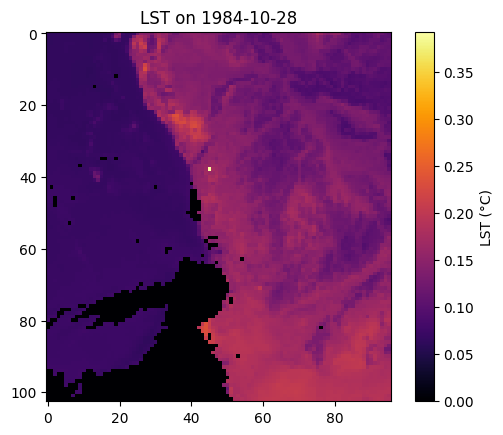

In [27]:
# Export one suspect image
image = landsat_indexed.filter(ee.Filter.eq('system:index', '1_1_2_LT05_170045_19841028')).first()

geemap.ee_export_image(
    image.select('LST'),
    filename='suspect_LST_19841028.tif',
    region=bbox,
    scale=1000
)

import rasterio
import matplotlib.pyplot as plt

with rasterio.open("jeddah_landsat_tiff/blue.tif") as src:
    lst = src.read(1)
    plt.imshow(lst, cmap='inferno')
    plt.colorbar(label='LST (°C)')
    plt.title("LST on 1984-10-28")
    plt.show()


In [8]:
ds = xr.open_dataset("/mnt/datawaha/hyex/gahwagrw/SaudiUHI/SASUHI/mk_landsat.nc")
existing_dates = pd.to_datetime(ds.time.values)
existing_dates_str = [d.strftime('%Y-%m-%d') for d in existing_dates]
exclude_ee_dates = ee.List(existing_dates_str)
def filter_dates(img):
    img_date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Algorithms.If(exclude_ee_dates.contains(img_date), None, img)   
landsat_indexed = landsat_indexed.map(lambda img: ee.Image(filter_dates(img))).filter(ee.Filter.notNull(['system:time_start']))



NameError: name 'landsat_indexed' is not defined

lst, uhi, urban cooling vs heating, id major cities, algorthim of use uhi index, scale it up to how it evovle with time, what factors contrubute? Anthopsecne ? energy demnd and human, 

what makes land heats up
how much clouds, humidy, aerosol, albedo, pressure, upper layer atmophere  is ther to contrubute to the lst 

is riyadh urban heating or cooling 

use geostatinary data to see day/night 

de treind rural from urban by getting two time sereis ? 

normalize the data per year 

how to average the urban area? 


